In [1]:
import pandas as pd 
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from xgboost import XGBClassifier

# ignorar los mensajes warning
import warnings
warnings.filterwarnings("ignore")

# mostrar todas las columnas y filas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [2]:
#lecturas de archivos
contratos = pd.read_csv("final_provider/contract.csv")
internet = pd.read_csv("final_provider/internet.csv")
personal = pd.read_csv("final_provider/personal.csv")
phone = pd.read_csv("final_provider/phone.csv")


In [3]:
# Convertir fechas a datetime
contratos['BeginDate'] = pd.to_datetime(contratos['BeginDate'])
contratos['EndDate'] = contratos['EndDate'].replace('No', pd.NaT)
contratos['EndDate'] = pd.to_datetime(contratos['EndDate'])

# Convertir TotalCharges a numérico
contratos['TotalCharges'] = pd.to_numeric(contratos['TotalCharges'], errors='coerce')

#excluimos clientes que su contrato inicio despues del 1 dde febrero del 2020
contratos = contratos[contratos["BeginDate"] < "01/02/2020"]


In [ ]:
# Unificamos los dataframes
df = contratos.merge(internet, on='customerID', how='left') \
              .merge(personal, on='customerID', how='left') \
              .merge(phone, on='customerID', how='left')


In [5]:
#Esto asignará 1 a los clientes que sí tienen fecha de finalización (cancelaron) y 0 a los que tienen 'No' (aún activos).
df['Churn'] = df['EndDate'].notna().astype(int)

In [6]:
# Llenamos los datos nulos de las columnas de servicios, los servicios externos son servicios si tienes internet, por lo tanto se agrego no a todos los que estaban nulos

columnas_objetivo = ["InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]

df_filtrado = df[(df["InternetService"] != 'Fiber optic') & (df["InternetService"] != 'DSL') ]

df_filtrado.loc[:,columnas_objetivo] =  df_filtrado[columnas_objetivo].fillna("No")

df.update(df_filtrado)

In [7]:
#se le agrega otra descripcion a la columna multiples lineas, ya que le hace falta un nuevo valor que indique que no tienen el servcio de telefono "not using"

df['MultipleLines'] =  df['MultipleLines'].fillna("Not using")

In [8]:
# eliminamos clientes inactivos (sin telefonia e internet)
inactivos = df[
    (df['InternetService'] == 'No') & (df['MultipleLines'] == 'Not using') ]

df = df.drop(inactivos.index).reset_index(drop=True)

In [9]:
#La fecha de referencia es el 1 de febrero de 2020. Vamos a crear una columna con la duración del contrato en meses.
fecha_corte = pd.to_datetime('2020-02-01')
df['SeniorityMonths'] = ((fecha_corte.year - df['BeginDate'].dt.year) * 12 +
                         (fecha_corte.month - df['BeginDate'].dt.month) +
                         (fecha_corte.day >= df['BeginDate'].dt.day).astype(int) - 1
                        )

In [10]:
# Vamos a contar cuántos servicios adicionales usa el cliente, Contar cuántos servicios son 'Yes'
servicios = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'MultipleLines'
]

df['ContratedServices'] = df[servicios].apply(lambda row: sum(row == 'Yes'), axis=1)

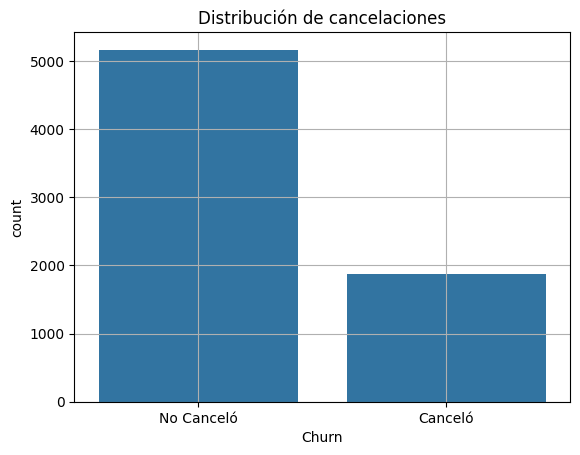

In [11]:
#distribucion general de la variable objetivo

sns.countplot(x='Churn', data=df)
plt.title('Distribución de cancelaciones')
plt.xticks([0,1], ['No Canceló', 'Canceló'])
plt.grid(True)
plt.show()

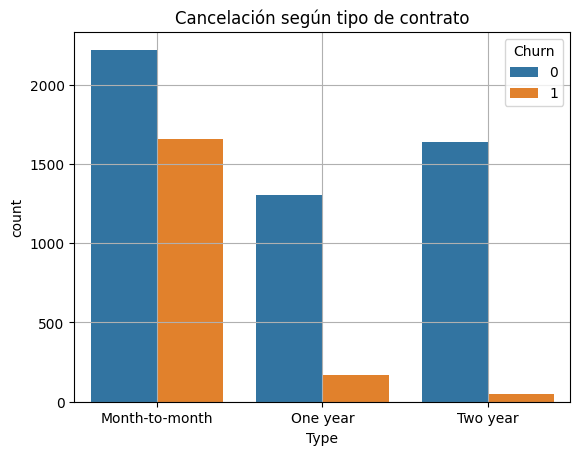

In [12]:
# cancelacion segun tipo de contrato
sns.countplot(x='Type', hue='Churn', data=df)
plt.title('Cancelación según tipo de contrato')
plt.grid(True)
plt.show()

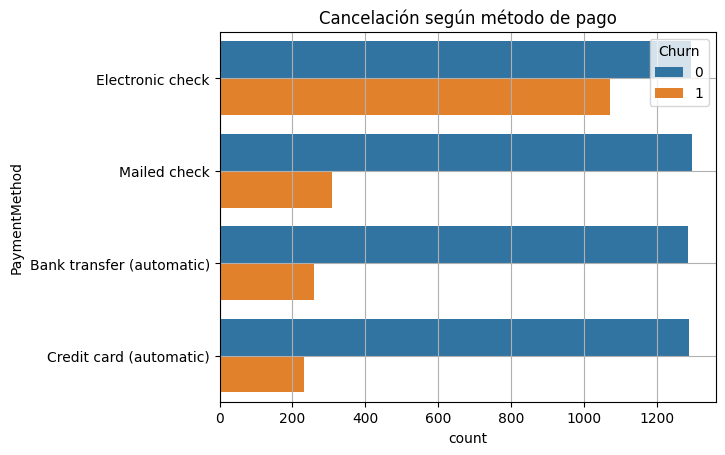

In [13]:
# cancelacion segun metodo de pago

sns.countplot(y='PaymentMethod', hue='Churn', data=df)
plt.title('Cancelación según método de pago')
plt.grid(True)
plt.show()

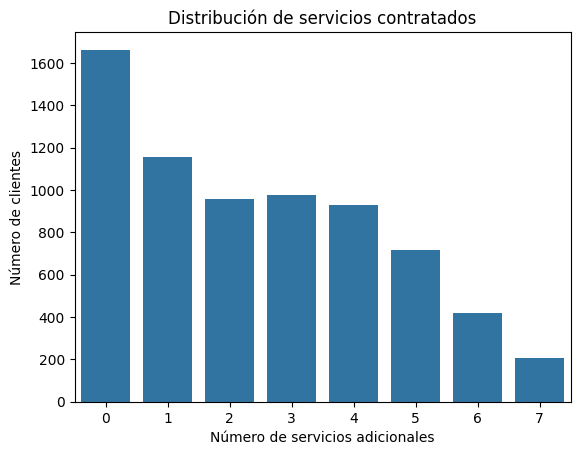

In [14]:

sns.countplot(x='ContratedServices', data=df)
plt.title('Distribución de servicios contratados')
plt.xlabel('Número de servicios adicionales')
plt.ylabel('Número de clientes')
plt.show()

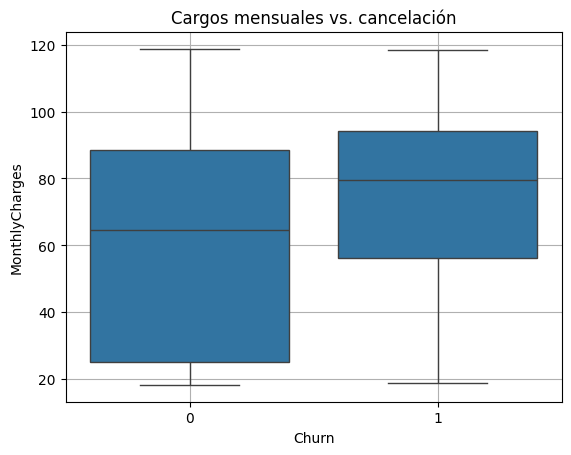

In [15]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Cargos mensuales vs. cancelación')
plt.grid(True)
plt.show()

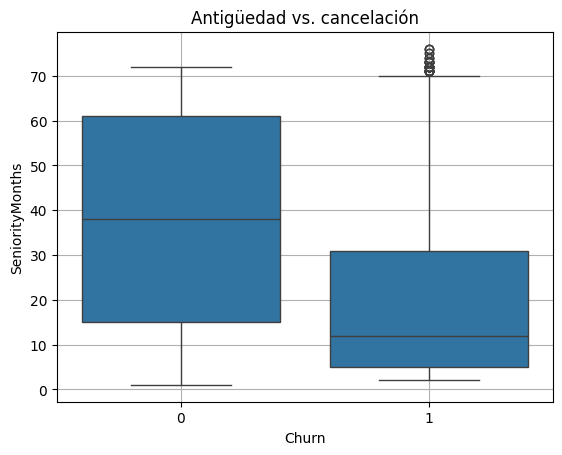

In [16]:
sns.boxplot(x='Churn', y='SeniorityMonths', data=df)
plt.title('Antigüedad vs. cancelación')
plt.grid(True)
plt.show()

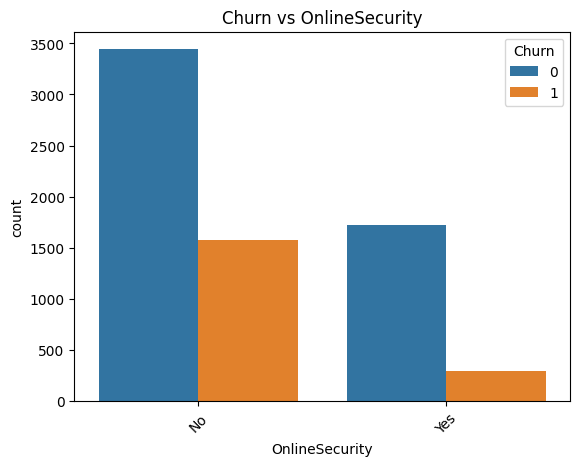

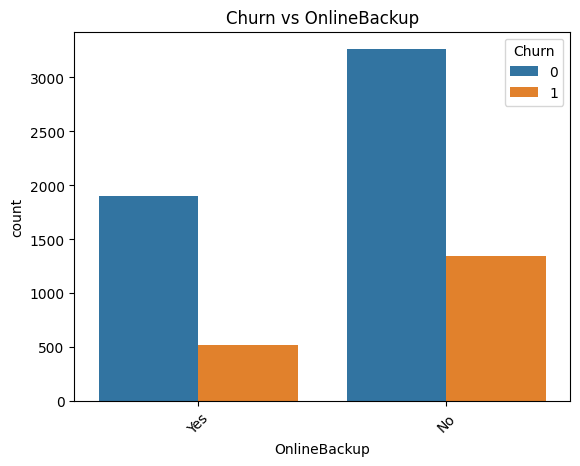

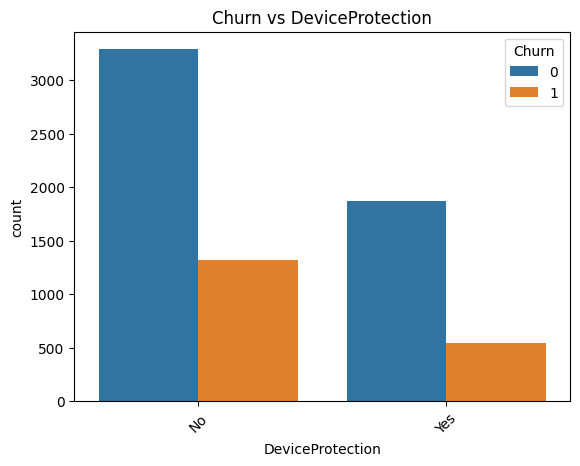

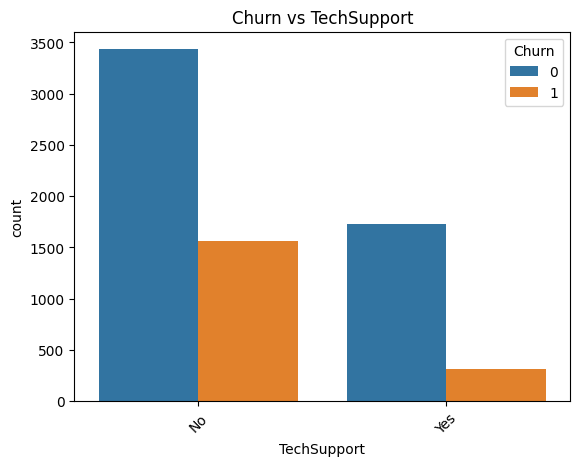

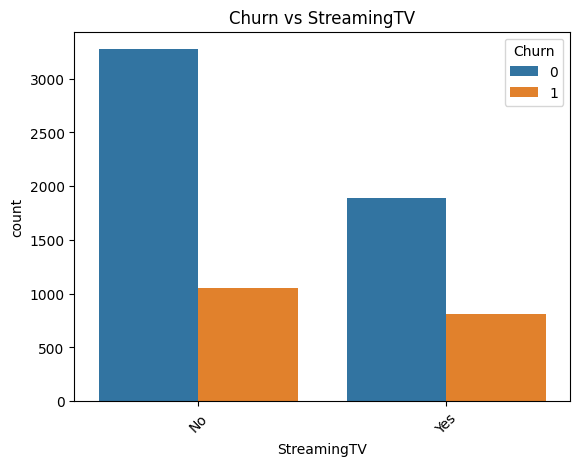

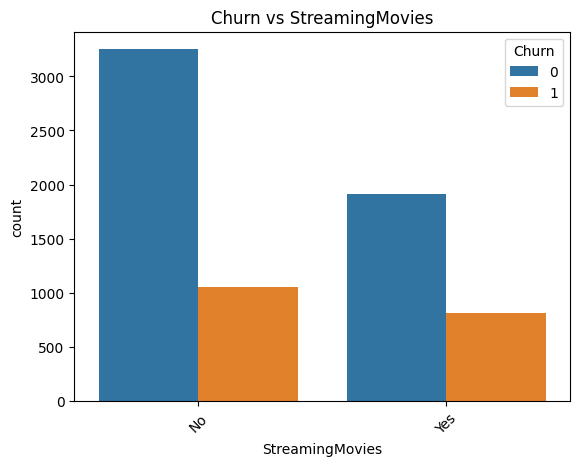

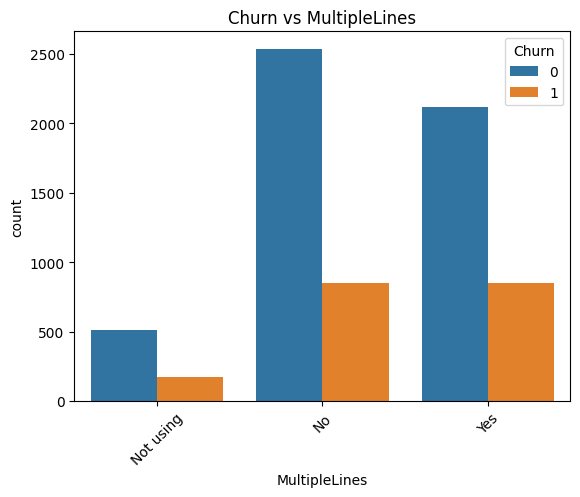

In [17]:
for col in servicios:
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'Churn vs {col}')
    plt.xticks(rotation=45)
    plt.show()

In [18]:
#Creamos una columna donde simplifiquemos los valores de PaymentMethod
df["payment"] =  np.where((df['PaymentMethod'] == 'Mailed check') | (df['PaymentMethod'] == 'Electronic check'),'Manual','Automatic')

# creamos el dataframe con la informacion que nos servira para el entrenamiento del modelo
df_model = df[["Type","PaperlessBilling","MonthlyCharges","TotalCharges","InternetService","MultipleLines","Churn","SeniorityMonths","ContratedServices","payment"]]

# Creacion de columnas binarias con label encoding

df_model["PaperlessBilling"] = df_model["PaperlessBilling"].map({'Yes':1,'No':0})
df_model["payment"] = df_model["payment"].map({"Automatic":1,"Manual":0})

# Multiclase con One-Hot-Encoding (sin duplicar informacion con drop_first=true)
df_model = pd.get_dummies(df_model,columns=["Type","InternetService","MultipleLines"], drop_first=True)


# Escalar variables numericas

scaler = StandardScaler()

num_cols = ['MonthlyCharges','TotalCharges','SeniorityMonths','ContratedServices']

df_model[num_cols] = scaler.fit_transform(df_model[num_cols])


In [19]:

df_model.sample(20)

,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,SeniorityMonths,ContratedServices,payment,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_No,MultipleLines_Not using,MultipleLines_Yes
2072,0,0.217784,-0.975885,1,-1.161357,-1.202856,0,False,False,True,False,False,False
1019,1,0.661544,-0.834197,0,-1.161357,-0.224940,0,False,False,True,False,False,False
3489,1,0.350746,-0.974120,1,-1.285402,-0.713898,0,False,False,True,False,False,True
6274,1,1.136883,-0.880566,1,-1.078661,0.752976,1,False,False,True,False,False,False
7018,1,-0.678045,-0.891309,0,-1.120009,-0.224940,0,False,False,False,False,True,False
2638,1,0.616670,0.209365,1,0.161789,-0.224940,0,False,False,True,False,False,True
939,1,0.500328,-0.124547,0,-0.375739,-0.713898,1,False,False,True,False,False,False
6210,1,-1.299642,-0.996025,1,-1.285402,-1.202856,0,False,False,False,False,True,False
1962,1,0.458778,1.355835,1,1.650328,1.730891,1,True,False,False,False,False,True
4767,1,1.146855,0.065318,1,-0.334391,0.752976,1,False,False,True,False,False,False


In [20]:
df.groupby("Churn").count()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,SeniorityMonths,ContratedServices,payment
Churn,,,,,,,,,,,,,,,,,,,,,,,
0,5163,5163,0,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163
1,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869


In [21]:
# separacion de el objetivo y las caracteristicas

features = df_model.drop(columns=["Churn"])
target = df_model["Churn"]

In [22]:
features.head()

,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorityMonths,ContratedServices,payment,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_No,MultipleLines_Not using,MultipleLines_Yes
0,1,-1.161694,-0.994194,-1.326751,-0.713898,0,False,False,False,False,True,False
1,0,-0.260878,-0.173740,0.037744,-0.224940,0,True,False,False,False,False,False
2,1,-0.363923,-0.959649,-1.202706,-0.224940,0,False,False,False,False,False,False
3,0,-0.747850,-0.195248,0.492575,0.264018,1,True,False,False,False,True,False
4,1,0.196178,-0.940457,-1.161357,-1.202856,0,False,False,True,False,False,False


In [23]:
# realizamos la separacion de entrenamiento y prueba
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)

In [24]:
print(target_train.value_counts())
print(target_test.value_counts())


Churn
0    4139
1    1486
Name: count, dtype: int64
Churn
0    1024
1     383
Name: count, dtype: int64


In [25]:
# implementamos tecnica SMOTE para el desbalanceo de clases, se aplica a los datos de entrenamiento

smote = SMOTE(random_state=12345)
features_train_resampled, target_train_resampled = smote.fit_resample(features_train,target_train)

In [26]:
target_train_resampled.value_counts()

Churn
0    4139
1    4139
Name: count, dtype: int64

In [27]:
# pasamos a crear nuestra baseline con DummyClassifier

dummy = DummyClassifier(strategy='most_frequent', random_state=12345)

auc_scores = cross_val_score(dummy, features_train_resampled,target_train_resampled, cv=5,scoring='roc_auc')

acc_scores = cross_val_score(dummy, features_train_resampled,target_train_resampled, cv=5,scoring='accuracy')

print(f" - AUC-ROC {np.mean(auc_scores):.4f}")
print(f" - Accuracy {np.mean(acc_scores):.4f}")


 - AUC-ROC 0.5000
 - Accuracy 0.4999


In [28]:
# evaluacion de modelos con metrica principal AUC-ROC  y Accuaracy

# utilizamos la validacion cruzada estratificada de 5 folds
sfk = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

# parametrizacion de los modelos
modelos = { "Logistic Regression": LogisticRegression(max_iter=1000, random_state=12345),
           "Random Forest": RandomForestClassifier(n_estimators=100, random_state=12345),
           "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss',random_state=12345)}


# iteramos el diccionario de los modelos para evaluar
for nombre, modelo in modelos.items():
    auc_scores = cross_val_score(modelo,features_train_resampled,target_train_resampled,cv=sfk,scoring='roc_auc')
    acc_scores = cross_val_score(modelo,features_train_resampled,target_train_resampled,cv=sfk,scoring='accuracy')

    print(f"{nombre}: AUC-ROC promedio = {auc_scores.mean():.4f} (+/- {auc_scores.std():.4f})")
    print(f"          Accuracy promedio = {acc_scores.mean():.4f}\n")



Logistic Regression: AUC-ROC promedio = 0.8328 (+/- 0.0115)
          Accuracy promedio = 0.7548

Random Forest: AUC-ROC promedio = 0.9532 (+/- 0.0036)
          Accuracy promedio = 0.8727

XGBoost: AUC-ROC promedio = 0.9700 (+/- 0.0035)
          Accuracy promedio = 0.9065



In [29]:
# como el modelo XGBoost es el mejor pasamos  a afinarlo
# usaremos RandomizedSearchCV para optimizar


# nuestro clasificador base
xgb_clf = XGBClassifier(use_label_encoder = False, eval_metric='logloss', random_state=12345)

#busqueda de hiperparametros
param_dist = {
    'n_estimators': [100,200,300],
    'max_depth': [3,5,7,10],
    'learning_rate': [0.01,0.05,0.1,0.2],
    'colsample_bytree': [0.6,0.8,1.0],
    'gamma': [0,0.1,0.3,0.5]
}

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    random_state=12345,
    n_jobs=-1
)

random_search.fit(features_train_resampled,target_train_resampled)

print('mejores parametros')
print(random_search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
mejores parametros
{'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.6}


In [30]:
# entrenamos el modelo con los parametros recomendados

model_xgb = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.2,
    gamma=0,
    colsample_bytree=0.6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=12345
)

model_xgb.fit(features_train_resampled,target_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

Matriz de confusion
[[945  79]
 [ 96 287]]

Reporte de clasificacion
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1024
           1       0.78      0.75      0.77       383

    accuracy                           0.88      1407
   macro avg       0.85      0.84      0.84      1407
weighted avg       0.87      0.88      0.87      1407


AUC-ROC: 0.9276


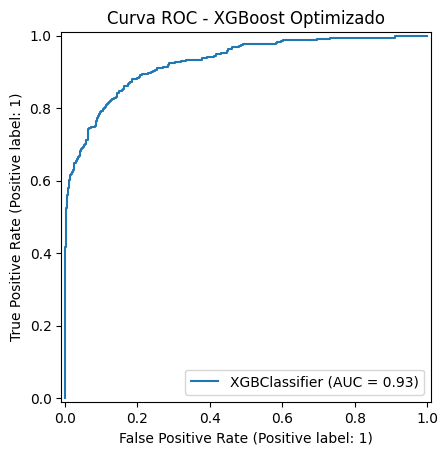

In [33]:
#predicciones 
target_predict = model_xgb.predict(features_test)
target_proba = model_xgb.predict_proba(features_test)[:,1]

print("Matriz de confusion")
print(confusion_matrix(target_test,target_predict))

print("\nReporte de clasificacion")
print(classification_report(target_test,target_predict))

auc = roc_auc_score(target_test,target_proba)
print(f"\nAUC-ROC: {auc:.4f}")


RocCurveDisplay.from_estimator(model_xgb,features_test,target_test)
plt.title("Curva ROC - XGBoost Optimizado")
plt.show()